In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format


import warnings
warnings.filterwarnings('ignore')

#### Function definitions for model result outputs

In [289]:
def lr_bayes_opt_resutls(model, hyper_min, hyper_max, n_iter, cv, xtrain, ytrain, xtest, ytest):
    opt = BayesSearchCV(model, 
                        {'alpha':Real(hyper_min,hyper_max, prior='uniform')},
                        cv=cv,
                        random_state=15,
                        n_iter=n_iter
                       )

    #training the data with the tuned hyperparameters from bayesian search
    opt.fit(xtrain, ytrain)
    
    m_name = ''
    if str(model) == str(Lasso()):
        m_name = 'Lasso'
    elif str(model) == str(Ridge()):
        m_name = 'Ridge'
        
    #TODO: adapt for multiple hyperparameters
    print('***** {} Tuned Hyperparameters *****'.format(m_name))
    print('Bayesian Search CV alpha value: {:.3g}'.format(opt.best_params_['alpha']))

    Y_train_pred = opt.predict(xtrain)
    Y_test_pred = opt.predict(xtest)

    #generating variables that contain the test statistics
    mae = mean_absolute_error(ytest, Y_test_pred)
    mean_sq_err = mse(ytest, Y_test_pred)
    root_mse = rmse(ytest, Y_test_pred)
    ma_perc_err = np.mean(np.abs((ytest - Y_test_pred) / ytest)) *100
        
    print('\n***** {} Training Set Statistics *****'.format(m_name))
    print('\nR-squared of the training set is: {:.3f}'.format(opt.score(xtrain, ytrain)))
    print('Root mean squared error of the training set is: {:.2f}'.format(rmse(ytrain, Y_train_pred)))
    print('\n***** {} Test Set Statistics *****'.format(m_name))
    print('\nR-squared of the test set is: {:.3f}'.format(opt.score(xtest, ytest)))
    print('Mean absolute error of the prediction is: {:.2f}'.format(mae))
    print('Mean squared error of the prediction is: {:.0f}'.format(mean_sq_err))
    print('Root mean squared error of the prediction is: {:.2f}'.format(root_mse))
    print('Mean absolute percentage error of the prediction is: {:.3f}\n'.format(ma_perc_err))
    
def enet_bayes_opt_results(hyper_min, hyper_max, n_iter, cv, xtrain, ytrain, xtest, ytest):
    opt = BayesSearchCV(ElasticNet(), 
                        {'alpha':Real(hyper_min, hyper_max, prior='uniform'),
                         'l1_ratio':Real(hyper_min, hyper_max, prior='uniform')},
                        cv=cv,
                        random_state=15,
                        n_iter=n_iter
                       )

    #training the data with the tuned hyperparameters from bayesian search
    opt.fit(xtrain, ytrain)

    #TODO: adapt for multiple hyperparameters
    print('***** ElasticNet Tuned Hyperparameters *****\n')
    print('Bayesian Search CV alpha value: {:.3g}'.format(opt.best_params_['alpha']))
    print('Bayesian Search CV l1_ratio value: {:.3g}'.format(opt.best_params_['l1_ratio']))
    
    Y_train_pred = opt.predict(xtrain)
    Y_test_pred = opt.predict(xtest)

    #generating variables that contain the test statistics
    mae = mean_absolute_error(ytest, Y_test_pred)
    mean_sq_err = mse(ytest, Y_test_pred)
    root_mse = rmse(ytest, Y_test_pred)
    ma_perc_err = np.mean(np.abs((ytest - Y_test_pred) / ytest)) *100

    print('\n***** ElasticNet Training Set Statistics *****')
    print('\nR-squared of the training set is: {:.3f}'.format(opt.score(xtrain, ytrain)))
    print('Root mean squared error of the training set is: {:.2f}'.format(rmse(ytrain, Y_train_pred)))
    print('\n***** ElasticNet Test Set Statistics *****')
    print('\nR-squared of the test set is: {:.3f}'.format(opt.score(xtest, ytest)))
    print('Mean absolute error of the prediction is: {:.2f}'.format(mae))
    print('Mean squared error of the prediction is: {:.0f}'.format(mean_sq_err))
    print('Root mean squared error of the prediction is: {:.2f}'.format(root_mse))
    print('Mean absolute percentage error of the prediction is: {:.3f}\n'.format(ma_perc_err))

# Data Loading

In [20]:
#data comes from Aimes, Iowa and is part of a kaggle competition
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

In [21]:
#Quick check on the number of rows and the columns in the dataframe
print(len(house_prices_df))
house_prices_df.iloc[:,:81].head(5)


1460


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# Exploratory Data Analysis

In [51]:
sns.set(style='darkgrid', palette='muted', rc={'figure.figsize':(12,5)})

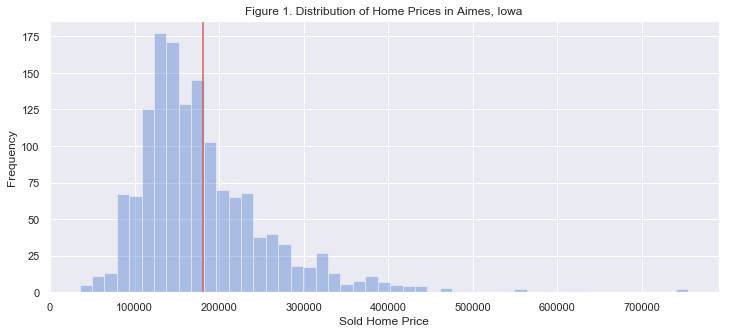

Mean home price in Ames: $180,921


In [53]:
#since we are estimating the saleprice I want to check the distribution
sns.distplot(house_prices_df['saleprice'], kde=False)
plt.xlabel('Sold Home Price')
plt.ylabel('Frequency')
plt.axvline(house_prices_df['saleprice'].mean(), color='r')
plt.title('Figure 1. Distribution of Home Prices in Aimes, Iowa')
plt.show()
print('Mean home price in Ames: ${:,.0f}'.format(house_prices_df['saleprice'].mean()))

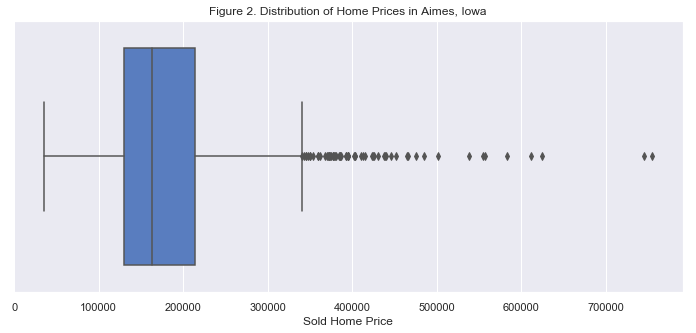

In [54]:
#checking for outliers in the distribution
sns.boxplot(house_prices_df['saleprice'])
plt.xlabel('Sold Home Price')
plt.title('Figure 2. Distribution of Home Prices in Aimes, Iowa')
plt.show()

##### Figure 2

The boxplot in figure 2 indicates that the homes above ~350,000 dollars are all outliers. It's hard to tell whether they are true outliers or are treated as such in the boxplot because the distribution of sales price is right-skewed (figure 1). In either case, this will be an important area to look out for as I continue the analysis.

Now that we've characterized the sales price, let's dig into some important features that could help predict the sales prices of homes in Ames, Iowa.

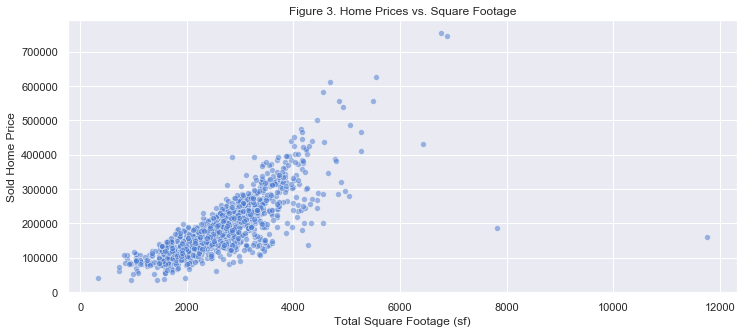

In [55]:
#creating a total square footage feature
house_prices_df['total_sf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

sns.scatterplot(house_prices_df['total_sf'], house_prices_df['saleprice'], alpha=0.5)
plt.xlabel('Total Square Footage (sf)')
plt.ylabel('Sold Home Price')
plt.title('Figure 3. Home Prices vs. Square Footage')
plt.show()

In [43]:
#zero-ing in on the abnormal homes with large sf and low sale price
outliers = house_prices_df.loc[(house_prices_df['total_sf'] > 7500)]
outliers.loc[:,['total_sf', 'saletype', 'mosold', 'yrsold', 'salecondition', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2', 'bsmtfinsf2', 'firstflrsf', 'secondflrsf', 'totalbsmtsf']]

,total_sf,saletype,mosold,yrsold,salecondition,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,firstflrsf,secondflrsf,totalbsmtsf
523,7814,New,10,2007,Partial,GLQ,2260,Unf,0,3138,1538,3138
1298,11752,New,1,2008,Partial,GLQ,5644,Unf,0,4692,950,6110


There seem to be a couple points that are outliers in the data with large square footage without the corresponding increase in price. The square footage breakdown looks realistic and is probably not the result of an input error. One odd thing about the home with 11,752 sq. feet is that the basement has a larger footprint than the first floor by 1,500 sq. feet. Also, it is important to note that the home sales indicate that the properties were newer builds and that the condition of the home was not verified because it wasn't completed at the last assessment. Both homes were sold around the same time during the recession. This could play a part in why they are selling far under their square footage. For now I will leave them in the dataset and try to use stock economic/financial data to explain the deviation from the trend.

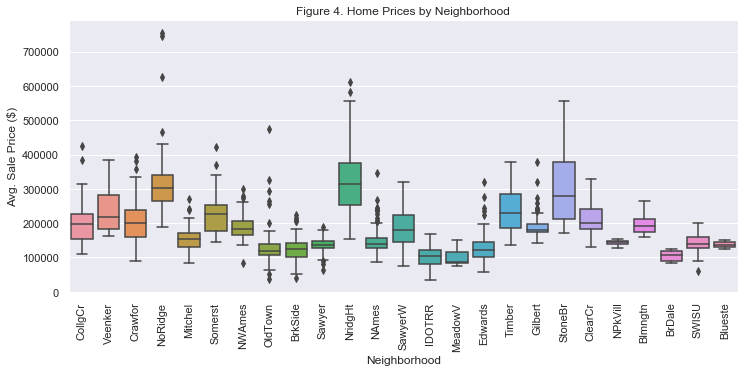

In [56]:
#neighborhood price breakout
sns.boxplot(x=house_prices_df['neighborhood'],
            y=house_prices_df['saleprice']
           )
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Avg. Sale Price ($)')
plt.title('Figure 4. Home Prices by Neighborhood')
plt.show()

The NoRidge, NridgHt, and StoneBr neighborhoods all have the highest average home price. Combining those neighborhoods into a feature could be used to explain the higher end of home prices in Ames. An additional feature to create will be the very upper end of the homes in those neighborhoods so that I can have a feature that will help predict the upper end of our price distribution. The square footage of the homes will be a nice way to 

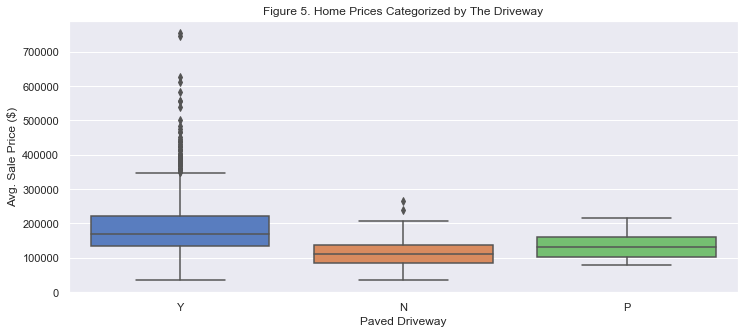

In [57]:
#paved driveway analysis
sns.boxplot(x=house_prices_df['paveddrive'],
            y=house_prices_df['saleprice']
           )
plt.xlabel('Paved Driveway')
plt.ylabel('Avg. Sale Price ($)')
plt.title('Figure 5. Home Prices Categorized by The Driveway')
plt.show()

There is a clear separation in home prices when homes have a paved driveway. Homes without a paved drive or a partial drive an average sell for less compared to homes with a paved driveway. There is a fair amount of overlap in the distributions of the three categories, but on average it is the paved driveways homes that are worth more.

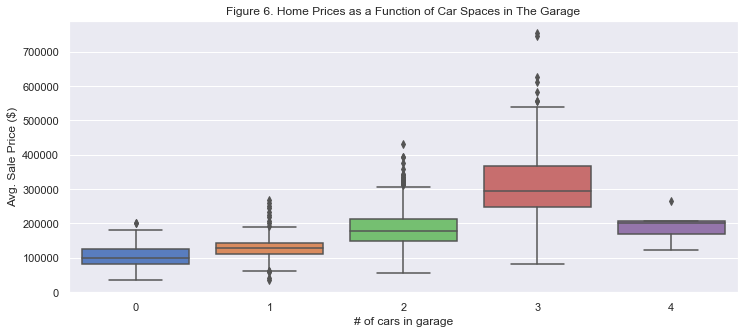

In [58]:
#characterizing the home price by spaces in the garage
sns.boxplot(x=house_prices_df['garagecars'],
            y=house_prices_df['saleprice']
           )
plt.xlabel('# of cars in garage')
plt.ylabel('Avg. Sale Price ($)')
plt.title('Figure 6. Home Prices as a Function of Car Spaces in The Garage')
plt.show()

There is a positive correlation with the average home price and 3 car garages. This binary feature could be used to predict the home prices. Aside from the size of the garage, there could be some more useful information about the garages that could help us predict home prices. For instance, does the type of garage a home has effect the sales price? What about whether or not it is finished?

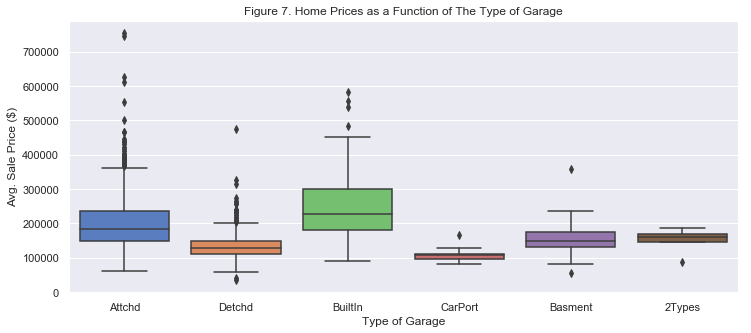

In [59]:
#garagetype will tell us where the garage is located in relation to the house
sns.boxplot(x=house_prices_df['garagetype'],
            y=house_prices_df['saleprice']
           )
plt.xlabel('Type of Garage')
plt.ylabel('Avg. Sale Price ($)')
plt.title('Figure 7. Home Prices as a Function of The Type of Garage')
plt.show()

The type of garage a home has could be used to explain the price of a home. The highest average sale prices are for attached garages and builtin garages (type of attached garage with liveable space above it). Because builtin garages are a type of attached garage I can engineer a feature that will take both types of garages into account.

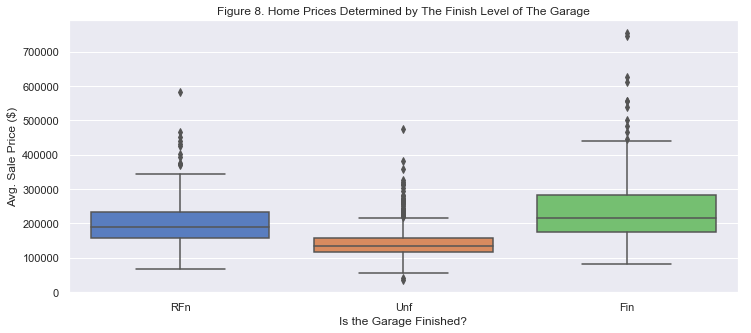

In [60]:
#evaluating whether a garage is finished or not's effect on saleprice
sns.boxplot(x=house_prices_df['garagefinish'],
            y=house_prices_df['saleprice']
           )
plt.xlabel('Is the Garage Finished?')
plt.ylabel('Avg. Sale Price ($)')
plt.title('Figure 8. Home Prices Determined by The Finish Level of The Garage')
plt.show()

Along with the other garage features i've talked about, whether or not a garage is finished will on average affect the sales price. Homes with garages that are finished out will on average be worth more money.

Enough about garages! 

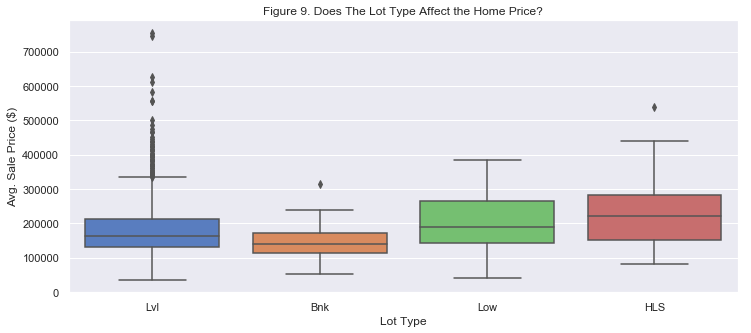

In [61]:
sns.boxplot(x=house_prices_df['landcontour'],
            y=house_prices_df['saleprice']
           )
plt.xlabel('Lot Type')
plt.ylabel('Avg. Sale Price ($)')
plt.title('Figure 9. Does The Lot Type Affect the Home Price?')
plt.show()

Figure 9 above shows that homes on a hillside on average are more expensive than homes in other lot settings. The home on level ground can get more expensive, but that is likely being controlled by another factor (sf, garagetype, etc.). Another component to the lot type will be the size of the yard. How does the yard size effect the home price?

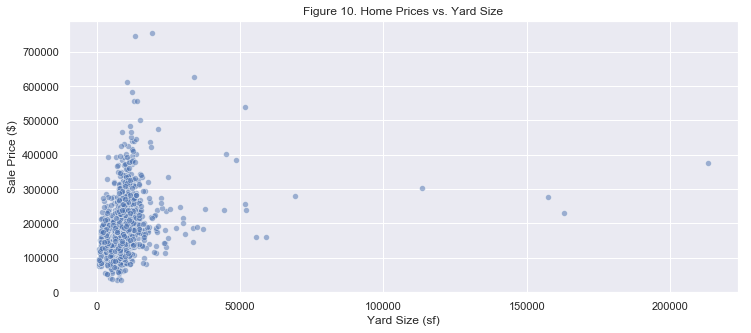

In [203]:
yard_sf = house_prices_df['lotarea'] - house_prices_df['firstflrsf']

sns.scatterplot(x=house_prices_df['yard_sf'], 
                y=house_prices_df['saleprice'], 
                alpha=0.5
               )
plt.xlabel('Yard Size (sf)')
plt.ylabel('Sale Price ($)')
plt.title('Figure 10. Home Prices vs. Yard Size')
plt.show()

It doesn't seem that in all cases there is a straightforward correlation between yard size and the homes value. However, there does seem to be a positive trend .

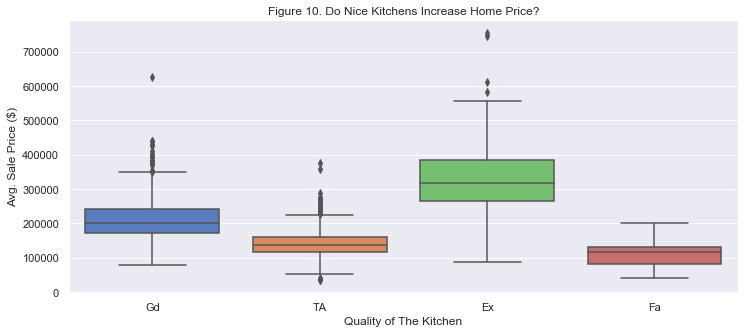

In [52]:
sns.boxplot(x=house_prices_df['kitchenqual'],
            y=house_prices_df['saleprice']
           )
plt.xlabel('Quality of The Kitchen')
plt.ylabel('Avg. Sale Price ($)')
plt.title('Figure 10. Do Nice Kitchens Increase Home Price?')
plt.show()

Excellent and good quality kitchens do have a higher average home value than the totally average and fair quality kitchens. Engineering a feature that will account for homes with above average kitchen quality will be helpful for the model.

# Feature Engineering

In [31]:
#hot encoding categorical features with positive correlation to salesprice
num_car_garage = pd.get_dummies(house_prices_df['garagecars'], prefix='car_garage')
house_prices_df = pd.concat([house_prices_df, num_car_garage], axis=1)

garage_type = pd.get_dummies(house_prices_df['garagetype'], prefix='garagetype')
house_prices_df = pd.concat([house_prices_df, garage_type], axis=1)

paved = pd.get_dummies(house_prices_df['paveddrive'], prefix='paved_driveway')
house_prices_df = pd.concat([house_prices_df, paved], axis=1)

garage_finish = pd.get_dummies(house_prices_df['garagefinish'], prefix='garagefinish')
house_prices_df = pd.concat([house_prices_df, garage_finish], axis=1)

hillside = pd.get_dummies(house_prices_df['landcontour'], prefix='landcontour')
house_prices_df = pd.concat([house_prices_df, hillside], axis=1)

#Does the house have an above average kitchen
house_prices_df['awesome_kitchen'] = 9999
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Ex') | (house_prices_df['kitchenqual'] == 'Gd'), 
                    ['awesome_kitchen']] = 1
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Fa') | (house_prices_df['kitchenqual'] == 'TA'), 
                    ['awesome_kitchen']] = 0
house_prices_df.awesome_kitchen.value_counts()

#Is the garage attached to the house feature
house_prices_df['attached_garage'] = 9999
house_prices_df.loc[(house_prices_df['garagetype'] == 'Attchd') | (house_prices_df['garagetype'] == 'BuiltIn'), 
                    ['attached_garage']] = 1
house_prices_df.loc[(house_prices_df['garagetype'] != 'Attchd') & (house_prices_df['garagetype'] != 'BuiltIn'), 
                    ['attached_garage']] = 0
house_prices_df.attached_garage.value_counts()

#estimating the size of the yard
house_prices_df['yard_sf'] = house_prices_df['lotarea'] - house_prices_df['firstflrsf']

#feature of the 3 neighborhoods with highest mean sales price
house_prices_df['pricey_neighborhoods'] = 9999

house_prices_df.loc[(house_prices_df.neighborhood == 'NoRidge') | 
                    (house_prices_df.neighborhood == 'NridgHt') | 
                    (house_prices_df.neighborhood == 'StoneBr'), 
                    ['pricey_neighborhoods']] = 1
house_prices_df.loc[(house_prices_df.neighborhood != 'NoRidge') & 
                    (house_prices_df.neighborhood != 'NridgHt') & 
                    (house_prices_df.neighborhood != 'StoneBr'), 
                    ['pricey_neighborhoods']] = 0   

#feature of homes in the pricey neighborhoods with over 4000 sq.feet
house_prices_df['pricey_hood_grt4000'] = 9999

house_prices_df.loc[(house_prices_df.pricey_neighborhoods == 1) & 
                    (house_prices_df.total_sf > 4000), 
                    ['pricey_hood_grt4000']] = 1
house_prices_df.loc[(house_prices_df.pricey_neighborhoods == 1) & 
                    (house_prices_df.total_sf < 4000), 
                    ['pricey_hood_grt4000']] = 0
house_prices_df.loc[house_prices_df.pricey_neighborhoods == 0, ['pricey_hood_grt4000']] = 0

# Model Iterations

### Model Train-Test Split

In [287]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin', 
                    'yard_sf', 
                    'landcontour_HLS', 
                    'pricey_neighborhoods', 
                    'pricey_hood_grt4000'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in test: {}'.format(len(X_test)))

#transforming the features so numerical differences do not affect the model
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

The number of observations in training: 1168
The number of observations in test: 292


### Ridge Model

In [290]:
lr_bayes_opt_resutls(Ridge(),
                     hyper_min=.0001,
                     hyper_max=1e24,
                     n_iter=50,
                     cv=10,
                     xtrain=X_train,
                     xtest=X_test,
                     ytrain=Y_train,
                     ytest=Y_test
                    )

***** Ridge Tuned Hyperparameters *****
Bayesian Search CV alpha value: 0.0001

***** Ridge Training Set Statistics *****

R-squared of the training set is: 0.800
Root mean squared error of the training set is: 35179.29

***** Ridge Test Set Statistics *****

R-squared of the test set is: 0.811
Mean absolute error of the prediction is: 24041.54
Mean squared error of the prediction is: 1265538719
Root mean squared error of the prediction is: 35574.41
Mean absolute percentage error of the prediction is: 13.598



### Lasso Model

In [291]:
lr_bayes_opt_resutls(Lasso(),
                     hyper_min=.0001,
                     hyper_max=1e24,
                     n_iter=50,
                     cv=10,
                     xtrain=X_train,
                     xtest=X_test,
                     ytrain=Y_train,
                     ytest=Y_test
                    )

***** Lasso Tuned Hyperparameters *****
Bayesian Search CV alpha value: 0.0001

***** Lasso Training Set Statistics *****

R-squared of the training set is: 0.800
Root mean squared error of the training set is: 35179.29

***** Lasso Test Set Statistics *****

R-squared of the test set is: 0.811
Mean absolute error of the prediction is: 24041.54
Mean squared error of the prediction is: 1265538675
Root mean squared error of the prediction is: 35574.41
Mean absolute percentage error of the prediction is: 13.598



### ElasticNet Model

In [295]:
enet_bayes_opt_results(
                        hyper_min=.001,
                        hyper_max=1e24,
                        n_iter=100,
                        cv=10,
                        xtrain=X_train,
                        xtest=X_test,
                        ytrain=Y_train,
                        ytest=Y_test
                      )

***** ElasticNet Tuned Hyperparameters *****

Bayesian Search CV alpha value: 0.001
Bayesian Search CV l1_ratio value: 0.001

***** ElasticNet Training Set Statistics *****

R-squared of the training set is: 0.800
Root mean squared error of the training set is: 35179.31

***** ElasticNet Test Set Statistics *****

R-squared of the test set is: 0.811
Mean absolute error of the prediction is: 24044.99
Mean squared error of the prediction is: 1266061303
Root mean squared error of the prediction is: 35581.76
Mean absolute percentage error of the prediction is: 13.601



## Model Results

Based on the results above, the three models perform almost identically with one another. The ElasticNet model technically is the worse performing of the three when considering the RMSE values of the three models (35,581 compared to 35,574). The generalization gap is identical between the three models at 0.011. Because the test set is outperforming the training set (assuming this is due to sample size) I think the generalization gap is less important. With those assumptions and considerations the Ridge or Lasso model is the best performer from above. The test set statistics, primarily the RMSE outperform the ElasticNet.

Now that we have baseline models with similar performance, I want to add in some external variables that could have an affect on the home prices in Ames. I want to add in financial data and employment statistics, which could both be a major influencer on the housing market at the city level.

# Additional External Data Sources

2009    338
2007    329
2006    314
2008    304
2010    175
Name: yrsold, dtype: int64


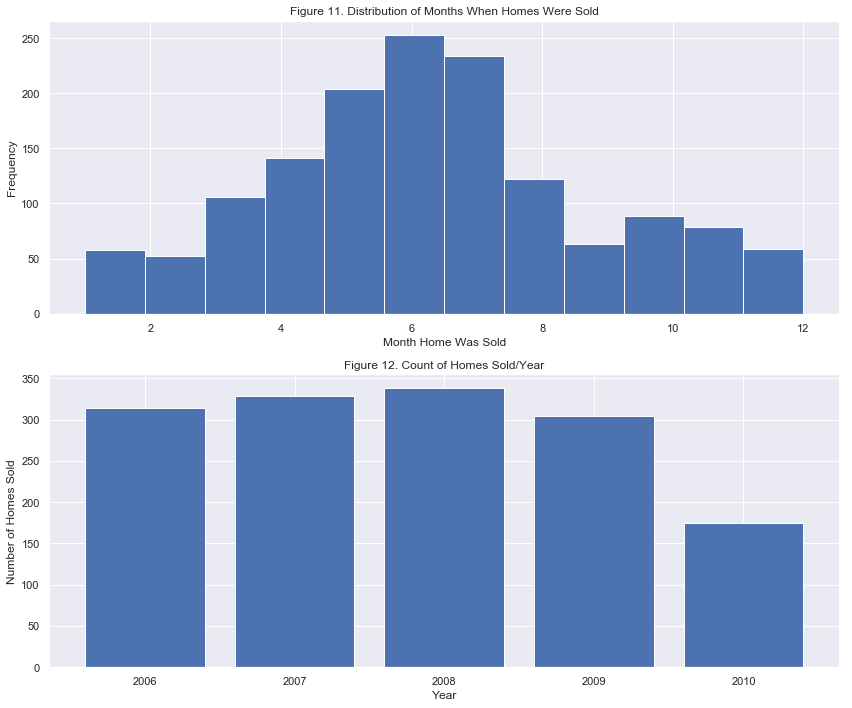

In [116]:
#want to determine the timeframe the house prices dataset represents
print(house_prices_df['yrsold'].value_counts())

plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(house_prices_df['mosold'], bins=12, align='mid')
plt.xlabel('Month Home Was Sold')
plt.ylabel('Frequency')
plt.title('Figure 11. Distribution of Months When Homes Were Sold')

plt.subplot(2,1,2)
plt.bar(house_prices_df['yrsold'].unique(),
        house_prices_df['yrsold'].value_counts()
       )
plt.xlabel('Year')
plt.ylabel('Number of Homes Sold')
plt.title('Figure 12. Count of Homes Sold/Year')

plt.tight_layout()
plt.show()

Figure 11 & 12 shows that most of the homes were sold during the summer months and that home sales started to decline after 2008.

### Adding S&P 500 Monthly Price Data

In [162]:
#average monthly S&P 500 price from 2006-2010, data from investing.com
stocks_df = pd.read_csv('sandp_500_2006_2010.txt', delimiter='\t', header=None)
stocks_df.columns = ['mosold', 'yrsold', 'sandp_price', 'open_price', 'high_price', 'low_price']

stocks_df['mosold'] = stocks_df['mosold'].astype('str')
stocks_df['yrsold'] = stocks_df['yrsold'].astype('str')

#creating month and year dictionaries to correct the stocks_df format
months = {
            'Jan':'1',
            'Feb':'2',
            'Mar':'3',
            'Apr':'4',
            'May':'5',
            'Jun':'6',
            'Jul':'7',
            'Aug':'8',
            'Sep':'9',
            'Oct':'10',
            'Nov':'11',
            'Dec':'12'
         }
years = {
            '6':'2006',
            '7':'2007',
            '8':'2008',
            '9':'2009',
            '10':'2010'
        }

#cleaning up the month and year columns in preparation of joining the two dataframes
for m in months:
    stocks_df['mosold'] = stocks_df['mosold'].str.replace(m, months[m])
for y in years:
    stocks_df['yrsold'] = stocks_df['yrsold'].str.replace(y, years[y])
stocks_df['sandp_price'] = stocks_df['sandp_price'].str.replace(',', '')

In [168]:
stocks_df[['mosold', 'yrsold',]] = stocks_df[['mosold', 'yrsold']].astype(int)
stocks_df['sandp_price'] = stocks_df['sandp_price'].astype(float)

#creating a combo date identifier to map the price to the house price dataframe
stocks_df['monthyear'] = stocks_df['mosold'].astype(str) + stocks_df['yrsold'].astype(str)
stocks_df.dtypes

mosold           int64
yrsold           int64
sandp_price    float64
open_price      object
high_price      object
low_price       object
monthyear       object
dtype: object

In [187]:
#creating the same combo date identifier to bring the price data into the dataframe
house_prices_df['monthyear'] = house_prices_df['mosold'].astype(str) + house_prices_df['yrsold'].astype(str)

In [186]:
#filtering the stock dataframe to only the two necessary columns
short_stocks_df = stocks_df[['monthyear', 'sandp_price']]

#converting the dataframe into a dictionary
ss = short_stocks_df.to_dict('split')
stock_split = ss['data']

#looping through the dictionary to get the correct prices to the right rows in house_prices_df
n = 0
t = 0
for i in stock_split:
    house_prices_df.loc[(house_prices_df['monthyear'] == stock_split[t][n]),
                        ['sandp500_price']] = stock_split[t][n+1]
    t += 1
house_prices_df['sandp500_price'].describe()

count   1460.000
mean    1228.465
std      206.327
min      735.090
25%     1036.190
50%     1276.660
75%     1400.380
max     1549.380
Name: sandp500_price, dtype: float64

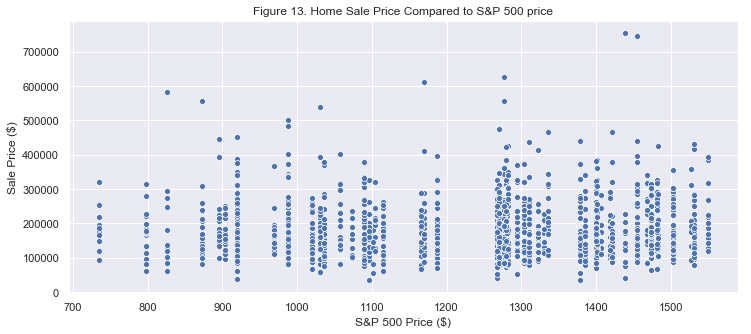

In [204]:
sns.scatterplot(x=house_prices_df['sandp500_price'],
                y=house_prices_df['saleprice']
               )
plt.xlabel('S&P 500 Price ($)')
plt.ylabel('Sale Price ($)')
plt.title('Figure 13. Home Sale Price Compared to S&P 500 price')
plt.show()

There isn't a strong correlation between the national scale S&P 500 index and the local home prices in Ames. This isn't completely discouraging because of the scale difference in the two datasets. Potentially more local indicators of the economy could have a correlation with the sales price of the homes.

### Adding Bureau of Labor Statistics (BLS) Data 

In [213]:
#ames employment statistics from the bureau of labor statistics
bls_ames = pd.read_csv('bls_ames_employment.csv', delimiter='\t', header=None)
bls_ames.columns = ['year', 'month', 'labor_force', 'employment', 'unemployment', 'unemployment_rate']
bls_ames.head(5)

,year,month,labor_force,employment,unemployment,unemployment_rate
0,2006,Jan,46744,45368,1376,2.900
1,2006,Feb,47959,46565,1394,2.900
2,2006,Mar,47515,46234,1281,2.700
3,2006,Apr,48157,47010,1147,2.400
4,2006,May,47642,46474,1168,2.500


In [214]:
bls_ames['year'] = bls_ames['year'].astype(str)

#formatting month column to create the monthyear id column
for m in months:
    bls_ames['month'] = bls_ames['month'].str.replace(m, months[m])

bls_ames['monthyear'] = bls_ames['month'] + bls_ames['year']

In [220]:
bls_ames_short = bls_ames[['monthyear', 'labor_force', 'employment', 'unemployment', 'unemployment_rate']]
bls_ames_dict = bls_ames_short.to_dict('split')
bls_data = bls_ames_dict['data']

#creating new blank columns in the master dataframe
for col in ['labor_force', 'employment', 'unemployment', 'unemployment_rate']:
    house_prices_df[col] = 9999

#assigning the data to the correct column in house_prices_df
n=0
t=0
for i in bls_data:
    house_prices_df.loc[(house_prices_df['monthyear'] == bls_data[t][n]),
                        ['labor_force']] = bls_data[t][n+1]
    house_prices_df.loc[(house_prices_df['monthyear'] == bls_data[t][n]),
                        ['employment']] = bls_data[t][n+2]
    house_prices_df.loc[(house_prices_df['monthyear'] == bls_data[t][n]),
                        ['unemployment']] = bls_data[t][n+3]
    house_prices_df.loc[(house_prices_df['monthyear'] == bls_data[t][n]),
                        ['unemployment_rate']] = bls_data[t][n+4]
    t += 1

house_prices_df[['labor_force', 'employment', 'unemployment', 'unemployment_rate']].head(5)

,labor_force,employment,unemployment,unemployment_rate
0,49426,47937,1489,3.000
1,47518,46271,1247,2.600
2,49516,48026,1490,3.000
3,47959,46565,1394,2.900
4,49657,47839,1818,3.700


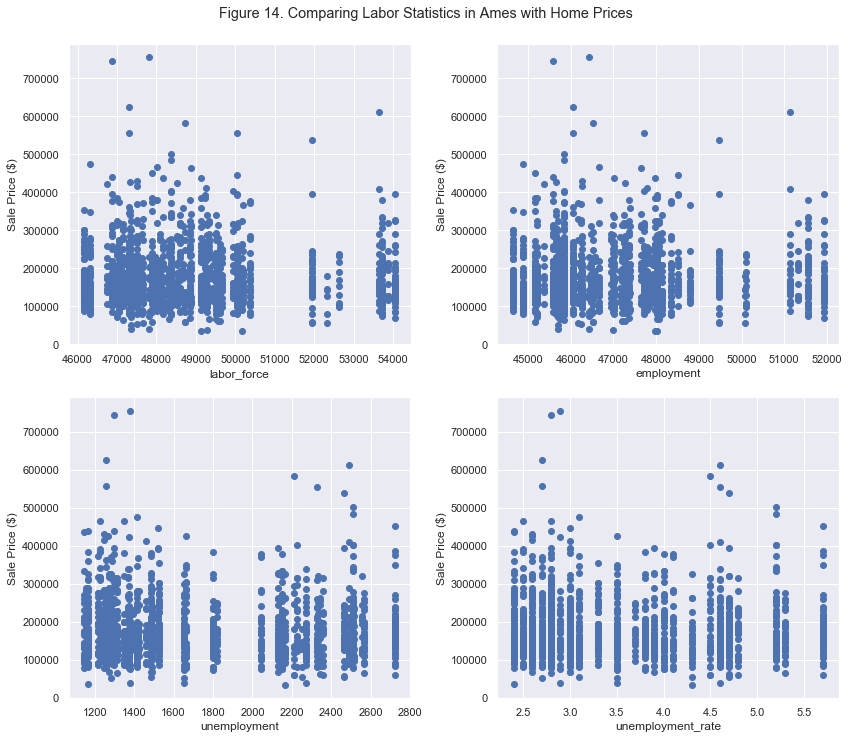

In [239]:
plt.figure(figsize=(12,10))
bls_stats = ['labor_force', 'employment', 'unemployment', 'unemployment_rate']

#plotting the labor stats against the home prices
n=1
for i in bls_stats:
    plt.subplot(2,2,n)
    plt.scatter(house_prices_df[i], house_prices_df['saleprice'])
    plt.ylabel('Sale Price ($)')
    plt.xlabel(i)
    n+=1
plt.suptitle('Figure 14. Comparing Labor Statistics in Ames with Home Prices', y=1.025)
plt.tight_layout()
plt.show()

There isn't much of a trend with any of the labor statistics in Ames and home prices. The few homes that did sell at the top of the market were sold when unemployment in Ames was at it's lowest.

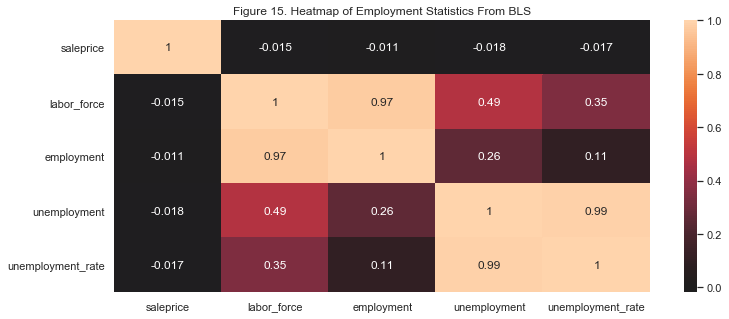

In [285]:
sns.heatmap(house_prices_df[['saleprice', 'labor_force', 'employment', 'unemployment', 'unemployment_rate']].corr(), center=0, annot=True)
plt.title('Figure 15. Heatmap of Employment Statistics From BLS')
plt.show()

Because the employment feature and the unemployment rate feature are the least correlatable with any of the other stats and are most correlatable with the salesprice, I will use them in the updated house price prediction model.

# Re-running the Lasso and ElasticNet Models

Since the Ridge and Lasso models were near identical before and the ElasticNet performed the best. I am going to re-train and predict sales price using only Lasso and ElasticNet. The hope would be to determine if any features were excluded during the Lasso model and see that benefit in the results of the ElasticNet Model

In [284]:
def lr_bayes_opt_resutls(model, hyper_min, hyper_max, n_iter, cv, xtrain, ytrain, xtest, ytest):
    opt = BayesSearchCV(model, 
                        {'alpha':Real(hyper_min,hyper_max, prior='uniform')},
                        cv=cv,
                        random_state=15,
                        n_iter=n_iter
                       )

    #training the data with the tuned hyperparameters from bayesian search
    opt.fit(xtrain, ytrain)
    
    m_name = ''
    if str(model) == str(Lasso()):
        m_name = 'Lasso'
    elif str(model) == str(Ridge()):
        m_name = 'Ridge'
        
    #TODO: adapt for multiple hyperparameters
    print('***** {} Tuned Hyperparameters *****'.format(m_name))
    print('Bayesian Search CV alpha value: {:.3g}'.format(opt.best_params_['alpha']))

    Y_train_pred = opt.predict(xtrain)
    Y_test_pred = opt.predict(xtest)

    #generating variables that contain the test statistics
    mae = mean_absolute_error(ytest, Y_test_pred)
    mean_sq_err = mse(ytest, Y_test_pred)
    root_mse = rmse(ytest, Y_test_pred)
    ma_perc_err = np.mean(np.abs((ytest - Y_test_pred) / ytest)) *100
        
    print('\n***** {} Training Set Statistics *****'.format(m_name))
    print('\nR-squared of the training set is: {:.3f}'.format(opt.score(xtrain, ytrain)))
    print('Root mean squared error of the training set is: {:.2f}'.format(rmse(ytrain, Y_train_pred)))
    print('\n***** {} Test Set Statistics *****'.format(m_name))
    print('\nR-squared of the validation set is: {:.3f}'.format(opt.score(xtest, ytest)))
    print('Mean absolute error of the prediction is: {:.2f}'.format(mae))
    print('Mean squared error of the prediction is: {:.0f}'.format(mean_sq_err))
    print('Root mean squared error of the prediction is: {:.2f}'.format(root_mse))
    print('Mean absolute percentage error of the prediction is: {:.3f}\n'.format(ma_perc_err))
    
def enet_bayes_opt_results(hyper_min, hyper_max, n_iter, cv, xtrain, ytrain, xtest, ytest):
    opt = BayesSearchCV(ElasticNet(), 
                        {'alpha':Real(hyper_min, hyper_max, prior='uniform'),
                         'l1_ratio':Real(hyper_min, hyper_max, prior='uniform')},
                        cv=cv,
                        random_state=15,
                        n_iter=n_iter
                       )

    #training the data with the tuned hyperparameters from bayesian search
    opt.fit(xtrain, ytrain)

    #TODO: adapt for multiple hyperparameters
    print('***** ElasticNet Tuned Hyperparameters *****\n')
    print('Bayesian Search CV alpha value: {:.3g}'.format(opt.best_params_['alpha']))
    print('Bayesian Search CV l1_ratio value: {:.3g}'.format(opt.best_params_['l1_ratio']))
    
    Y_train_pred = opt.predict(xtrain)
    Y_test_pred = opt.predict(xtest)

    #generating variables that contain the test statistics
    mae = mean_absolute_error(ytest, Y_test_pred)
    mean_sq_err = mse(ytest, Y_test_pred)
    root_mse = rmse(ytest, Y_test_pred)
    ma_perc_err = np.mean(np.abs((ytest - Y_test_pred) / ytest)) *100

    print('\n***** ElasticNet Training Set Statistics *****')
    print('\nR-squared of the training set is: {:.3f}'.format(opt.score(xtrain, ytrain)))
    print('Root mean squared error of the training set is: {:.2f}'.format(rmse(ytrain, Y_train_pred)))
    print('\n***** ElasticNet Test Set Statistics *****')
    print('\nR-squared of the validation set is: {:.3f}'.format(opt.score(xtest, ytest)))
    print('Mean absolute error of the prediction is: {:.2f}'.format(mae))
    print('Mean squared error of the prediction is: {:.0f}'.format(mean_sq_err))
    print('Root mean squared error of the prediction is: {:.2f}'.format(root_mse))
    print('Mean absolute percentage error of the prediction is: {:.3f}\n'.format(ma_perc_err))

In [283]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin', 
                    'yard_sf', 
                    'landcontour_HLS', 
                    'pricey_neighborhoods', 
                    'pricey_hood_grt4000',
                    'sandp500_price',
                    'employment',
                    'unemployment_rate'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('The number of observations in training: {}'.format(len(X_train)))
print('The number of observations in test: {}\n'.format(len(X_test)))

#transforming the features so numerical differences do not affect the model
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

lr_bayes_opt_resutls(Lasso(),
                     hyper_min=.001,
                     hyper_max=1e24,
                     n_iter=75,
                     cv=10,
                     xtrain=X_train,
                     xtest=X_test,
                     ytrain=Y_train,
                     ytest=Y_test
                    )

enet_bayes_opt_results(
                        hyper_min=.001,
                        hyper_max=1e24,
                        n_iter=75,
                        cv=10,
                        xtrain=X_train,
                        xtest=X_test,
                        ytrain=Y_train,
                        ytest=Y_test
                      )

The number of observations in training: 1168
The number of observations in test: 292
Bayesian Search CV alpha value: 0.001

***** Lasso Training Set Statistics *****

R-squared of the training set is: 0.801
Root mean squared error of the training set is: 35157.73

***** Lasso Test Set Statistics *****

R-squared of the validation set is: 0.812
Mean absolute error of the prediction is: 23983.78
Mean squared error of the prediction is: 1262539382
Root mean squared error of the prediction is: 35532.23
Mean absolute percentage error of the prediction is: 13.526

Bayesian Search CV alpha value: 0.001
Bayesian Search CV l1_ratio value: 0.001

***** ElasticNet Training Set Statistics *****

R-squared of the training set is: 0.801
Root mean squared error of the training set is: 35157.74

***** ElasticNet Test Set Statistics *****

R-squared of the validation set is: 0.812
Mean absolute error of the prediction is: 23987.60
Mean squared error of the prediction is: 1263069977
Root mean squared er

# Conclusions & Future Improvements

As expected, since the added features did not correlate strongly with home prices, they had very little effect on the predictive power of the models. Technically the R-squared of the training set did increase for each model, therefore reducing the generalization gap, however it was a very small improvement. Both models did have a slightly improved test set RMSE when compared to the original iterations of the Lasso and ElasticNet models (initial RMSE = 35572, updated RMSE = 35539). 

One explanation for the ineffectiveness of employment statistics on home prices is that jobs were added or lost in the town, but they were not in the demographic of people that would be buying homes. Comparing the monthly average incomes with home prices could be more beneficial than just the number of people who have jobs or not. 

    Below is a list of future avenues to dig into that are outside of the dataset:
    - Average annual income of potential homebuyers (source: census)
    - Additional local/regional economic data (source: census/state)
    - Interest rate data matching the time period of the dataset (source: fed)
    - Market total volumes for sold and inventory (source: city MLS(?))
    
Ultimately, I would choose the models without the financial/employment statistics included due to the lower complexity that yields the same predictive power based on the current train/test sets.